<h1 style="font-size:40px;"><center>Exercise I:<br> Training of simple MLP models
</center></h1>


# Short summary
In this exercise you will: 

* train MLPs and for simple classification and regression problems.
* learn how hyper parameters such as learning rate, batch size and number of epochs effect the training.

There are 8 questions in this exercise. These 8 questions can be found in three different cells below (see section "The Different Cells"). 

You should write the report of the exercise within this notebook. The details of how to do that can be found below in section "Writing the report". Finally before you start:

**Deadline for submitting the report: November 26, 13:00 (2021)**

## The data
We will use two synthetic different data sets in this exercise

### syn2
The *syn2* dataset represents a binary classification problem. The input data is 2D which allows for an easy visual inspection of the different classes and the decision boundary implemented by the network. The dataset is generated "on the fly" each time. Data are generated from various normal distributions. Since they are generated using random numbers it means that each time you generate the data it will be slightly different from next time. You can control this by having a fixed *seed* to the random number generator. The cell "PlotData" will plot the *syn2* dataset.

### regr1
There is also a synthetic regression problem, called *regr1*. It has one input and one output (target) variable. It a cosinus function, with the possibility to add some noise and dampening on the output. Again see the cell "PlotData" to look at the dataset.

## The exercises
There are 8 questions, where the first 6 questions will use the *regr1* dataset and question 7-8 will use *syn2*.

## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | MLP | Needed | Defines the MLP model |
| 3 | Data | Needed | Defines the functions to generate the artificial datasets |
| 4 | PlotData | Information | Plots the 2D classification datasets |
| 5 | Statistics | Needed | Defines the functions that calculates various performance measures |
| 6 | Boundary | Needed | Function that can show 2D classification boundaries | 
| 7 | Ex1 | Exercise | For question 1-4 |
| 8 | Ex2 | Exercise | For question 5-6 |
| 9 | Ex3 | Exercise | For question 7-8 |

In order for you to start with the exercise you need to run all cells with the celltype "Needed". The very first time you start with this exercise we suggest that you enter each of the needed cells, read the cell instruction and run the cell. It is important that you do this in the correct order, starting from the top and work you way down the cells. Later when you have started to work with the notebook it may be easier to use the command "Run All" or "Run all above" found in the "Cell" dropdown menu.

## Writing the report
First the report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name:
* Introduction: A **few** sentences where you give a small introduction of what you have done in the lab.
* Answers to questions: For each of the questions provide an answer. It can be short answers or a longer ones depending on the nature of the questions, but try to be effective in your writing.
* Conclusion: Summarize your findings in a few sentences.

It is important that you write the report in this last cell and **not** after each question! 

## Last but not least
Have fun!

---

### CellName: Init (#1)
### CellType: Needed
### Cell instruction: Initializing the libraries

In the cell below, we will import needed libraries. 

Run the cell by entering into the cell and press "CTRL Enter".

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, regularizers, optimizers
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import scipy as sp
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, log_loss, classification_report
import pandas as pd

### CellName: MLP (#2)
### CellType: Needed
### Cell instruction: Defining the MLP model

This cell defines the MLP model. There are a number of parameters that is needed to 
define a model. Here is a list of them: **Note:** They can all be specified when you call
this function in later cells. The ones specified in this cell are the default values.

* inp_dim: the input dimension (integer)

* n_nod: size of the network, eg [5] for a one hidden layer with 5 nodes and [5,3] for a two layer network with 5 and 3 hidden nodes each.

* act_fun: the activation function. Most common are
    * 'relu'
    * 'tanh'
        
* out_act_fun: the activation function for the output nodes. Most common are
    * 'linear'
    * 'sigmoid'
    * 'softmax'
    
* opt_method: The error minimization method. Common choices
    * 'SGD'
    * 'Adam'
    
* cost_fun: The error function used during training. There are three common ones
    * 'mean_squared_error'
    * 'binary_crossentropy'
    * 'categorical_crossentropy'

* lr_rate: The learning rate.

* metric: The metric to use besides the loss. Common values
    * accuracy
    * mse

Run the cell by entering into the cell and press "CTRL Enter".

In [2]:
def mlp(inp_dim,
            n_nod,
            act_fun = 'tanh',
            out_act_fun = 'linear',
            opt_method = 'SGD',
            cost_fun = 'mse',
            lr_rate = 0.01,
            metric = 'mse',
            num_out = None):
    
    lays = [inp_dim] + n_nod
    
    main_input = Input(shape=(inp_dim,), dtype='float32', name='main_input')
    
    X = main_input
    for i, nod in enumerate(n_nod):
        X = Dense(nod, 
                  activation = act_fun)(X)
        
    output = Dense(1, activation = out_act_fun )(X)
    
    method = getattr(optimizers, opt_method)
    
    model =  Model(inputs=[main_input], outputs=[output])
    model.compile(optimizer = method(lr = lr_rate),
                  loss = cost_fun,
                  metrics=[metric])       

    return model

### CellName: Data (#3)
### CellType: Needed
### Cell instruction: Defining synthetic data sets

This cell defines the two synthetic datasets. The last function is used for standardization of the data. 

Run the cell by entering into the cell and press "CTRL Enter".

In [3]:
def syn2(N):
    
    global seed
     
    x = np.empty(shape=(N,2), dtype = np.float32)  
    d = np.empty(shape=(N,), dtype = np.float32) 
    N1 = int(N/2)

    # Positive samples
    x[:N1,:] = 0.8 + np.random.normal(loc=.0, scale=1., size=(N1,2))

    # Negative samples 
    x[N1:,:] = -.8 + np.random.normal(loc=.0, scale=1., size=(N-N1,2))
    
    # Target
    d[:N1] = np.ones(shape=(N1,))
    d[N1:] = np.zeros(shape=(N-N1,))

    return x,d


def regr1(N, len = 2, damp=0, v=0):

    global seed

    dx = 2*len*np.pi /(N-1)
    x = np.empty(N, dtype = np.float32) 
    for i in range(N):
        x[i] = i*dx
    
    noise =  lambda  n : np.random.normal(0,1,n)
    if damp == 1:
        d = np.cos(x)*np.exp(-x*0.05)
    else:
        d = np.cos(x)
    
    std_signal = np.std(d)
    d = d + v * std_signal * noise(N)
        
    return x, d


def standard(x):
    return np.mean(x, axis=0) , np.std(x, axis=0)

### CellName: PlotData (#4)
### CellType: Information
### Cell instruction: Plotting the data

Here we just generate 100 cases for *syn2* and the *regr1* dataset and plot them. 

Run the cell by entering into the cell and press "CTRL Enter". 

**Note!** This cell is not needed for the actual exercises, it is just to visualize the two datasets.

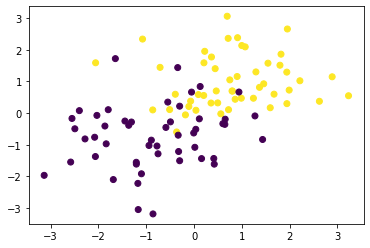

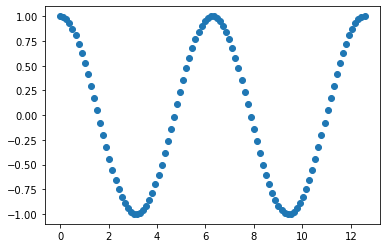

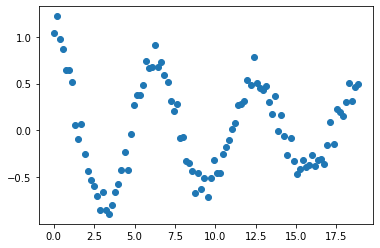

In [4]:
# seed = 0 means random, seed > 0 means fixed
seed = 5
np.random.seed(seed) if seed else None

x,d = syn2(100)
plt.figure(1)
plt.scatter(x[:,0],x[:,1], c=d)

# Regression, one period, no noise
x,d = regr1(100, 2, 0, 0)
plt.figure(2)
plt.scatter(x,d)

# Regression, 1.5 period, exponential damping, some noise
x,d = regr1(100, 3, 1, 0.2)
plt.figure(3)
plt.scatter(x,d)


### CellName: Statistics (#5)
### CellType: Needed
### Cell instruction: Present result for both classification and regression problems

This cell defines two functions that we are going to call using a trained model to calculate both error and performance measures. 

Run the cell by entering into the cell and press "CTRL Enter".

In [5]:
def stats_class(x = None, y = None, label = 'Training', modl = None):
    """
    input :  
             x = input
             y = output
             label = "Provided text string"
             modl = the model
             
    output : 
             accuracy = fraction of correctly classified cases
             loss = typically the cross-entropy error
    """
    
    def binary(y1):
        y1[y1>.5] = 1.
        y1[y1<= .5] = 0.        
        return y1

    y_pr = modl.predict(x, batch_size = x.shape[0], verbose=0).reshape(y.shape)
                
    nof_p, tp, nof_n, tn = [np.count_nonzero(k) for k in [y==1, y_pr[y==1.] > 0.5, y==0, y_pr[y==0.]<= 0.5]]
    
    acc = (tp + tn) / (len(y))
    loss = modl.evaluate(x, y , batch_size =  x.shape[0], verbose=0)
                
    A = ['Accuracy', 'CEE']
    B = [acc, loss[0]]
    
    print('\n','#'*10,'STATISTICS for {} Data'.format(label), '#'*10, '\n')
    for i in range(len(A)):
        print('{:15} {:.4f}'.format(A[i], B[i]))

    return print('\n','#'*50)

def stats_reg(d = None, d_pred = None, label = 'Training', estimat = None):
    
    A = ['MSE']
    
    if label.lower() in ['training', 'trn', 'train']:
        mse = estimat.history['loss'][-1]
    else:
        mse = estimat.history['val_loss'][-1] 

    B = [mse]
    
    print('\n','#'*10,'STATISTICS for {} Data'.format(label), '#'*10, '\n')
    for i in range(len(A)):
        print('{:15} {:.10f}'.format(A[i], B[i]))

    return print('\n','#'*50)


### CellName: Boundary (#6)
### CellType: Needed
### Cell Instruction: Decision boundary

This cell defines the function to plot the decision boundary for a 2D input binary MLP classifier. In short, this function defines a grid covering the input data. Each grid point is then used as an input to the trained MLP and to compute an output. If the output is close to 0.5 it is marked as the boundary. 

Run the cell by entering into the cell and press "CTRL Enter".

In [6]:
def decision_b(X, Y1, model ):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    # grid stepsize
    h = 0.025

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    Z[Z>.5] = 1
    Z[Z<= .5] = 0

    Y_pr = model.predict(X, batch_size = X.shape[0], verbose=0).reshape(Y1.shape)
  
    Y = np.copy(Y1)
    Y_pr[Y_pr>.5] = 1
    Y_pr[Y_pr<= .5] = 0
    Y[(Y!=Y_pr) & (Y==0)] = 2
    Y[(Y!=Y_pr) & (Y==1)] = 3
    
    
    plt.figure()
    #plt.contourf(xx, yy, Z, cmap=plt.cm.PRGn, alpha = .9) 
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    
    
    plt.scatter(X[:, 0][Y==1], X[:, 1][Y==1], marker='+', c='k')
    plt.scatter(X[:, 0][Y==0], X[:, 1][Y==0], marker='o', c='k')
       
    plt.scatter(X[:, 0][Y==3], X[:, 1][Y==3], marker = '+', c='r')   
    plt.scatter(X[:, 0][Y==2], X[:, 1][Y==2], marker = 'o', c='r')
    
    
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.show()


---
End of "Needed" and "Information" cells. Below are the cells for the actual exercise.

---

### CellName: Ex1 (#7)
### CellType: Exercise
### Cell instruction: Instruction for question 1-4
The cell below should be used for questions 1-4.

The following questions will look at three essential parameters that controls the training process of an MLP. By training process we mean here the minimization of the given loss function. The parameters are the *learning rate*, *batch size* and *number of epochs* (or epochs for short). The task is to train an MLP that can fit the *regr1* dataset, i.e. a regression problem. Given the nature of this regression problem we know that we will need more than one hidden node. From experience we know that four hidden nodes are enough to accurately fit the training data, hence we will use four hidden nodes for this first exercise. 

The exercise will study how the learningrate, batchsize and epochs influences the training. A successful training means here when the networks has reached a low loss (< 0.01) and visually have fitted the data accurately. In this exercise we do not care about possible overfitting, only about the minimization of the loss function, we therefore do not have a validation dataset.

#### Question 1
For the first question you can simply run the cell below. It will load 50 samples from the *regr1* dataset (no noise added). The network has 4 hidden nodes in a single hidden layer, *tanh* activation function, linear output activation function, *stochastic gradient descent* as minimization method, MSE loss function, and a learning rate of 0.05.
It will train for 4000 epochs using a batchsize of 50, meaning that we efficiently are using ordinary gradient descent learning. Run this cell five times. **(a) Do you see the same loss vs epoch behavior each time your run?** If no **why?**. **(b) Do you observe that training fails, i.e. do not reach low loss, during these five runs?** 

#### Question 2
You will now study what happens when you train with different learning rates. Train with different learning rates in the range 0.001 to 0.5. Test at least 5 different learning rates in that range and for each learning rate train the network three times and record the average MSE value over these three runs. **Discuss your findings**.

**Note:** You should keep the same settings as for Q1, only vary the learning rate. 

#### Question 3
We now (hopefully) have discovered that the size of the learning rate have an influence of the efficiency of the minimization of the loss function. We will now look at what happens when we use *stochastic gradient descent*, meaning that we will have a batch size that is smaller the the size of the training data. Use a fixed learning rate of 0.05, but test different batch sizes in the range 1 to 50. Again train three different networks for each batch size, but this time record if the training was successful (i.e. MSE < 0.01) and approximately after how many epochs the good solution was found. **Discuss your findings**.

#### Question 4
Now we want to vary both the learning rate and the batch size to find an optimal setting for training this network. Your task is to find a combination of learning rate and batch size that will find a good solution within 1000 epochs. We always have to remember that two runs with identical hyper parameters (e.g. learning rate, batch size etc) will result in different final results. Your set of parameters should *most* for the times result in a good solution within 1000 epochs. **Present your best combination of learning rate and batch size**.


Model: "model_153"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
dense_306 (Dense)            (None, 4)                 8         
_________________________________________________________________
dense_307 (Dense)            (None, 1)                 5         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


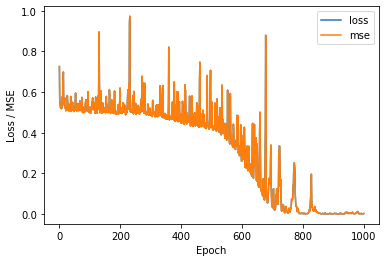


 ########## STATISTICS for Training Data ########## 

MSE             0.0023990474

 ##################################################


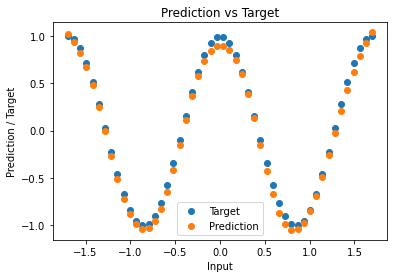

CPU times: user 7.63 s, sys: 1.08 s, total: 8.71 s
Wall time: 5.43 s


In [160]:
%%time
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

# Generate training data
x_trn, d_trn = regr1(50, 2, 0, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu)/std

# Define the network, cost function and minimization method
INPUT1 = {'inp_dim': 1,         
         'n_nod': [4],                   # number of nodes in hidden layer
         'act_fun': 'tanh',              # activation functions for the hidden layer
         'out_act_fun': 'linear',        # output activation function
         'opt_method': 'SGD',            # minimization method
         'cost_fun': 'mse',              # error function
         'lr_rate': 0.05                # learningrate
        }        

# Get the model
model_ex1 = mlp(**INPUT1)

# Print a summary of the model
model_ex1.summary()

# Train the model
estimator_ex1 = model_ex1.fit(x_trn, d_trn,
                              epochs = 1000,      
                              batch_size=25,
                              verbose = 0)


# Training history
plt.figure()
plt.ylabel('Loss / MSE')
plt.xlabel('Epoch')
for k in estimator_ex1.history.keys():
    plt.plot(estimator_ex1.history[k], label = k) 
plt.legend(loc='best')
plt.show()

# Call the stat_reg to get MSE
pred_trn = model_ex1.predict(x_trn).reshape(d_trn.shape)
stats_reg(d_trn, pred_trn, 'Training', estimator_ex1)

# Plot the result
d_pred = model_ex1.predict(x_trn)
plt.figure()
plt.ylabel('Prediction / Target')
plt.xlabel('Input')
plt.scatter(x_trn, d_trn, label='Target')
plt.scatter(x_trn, d_pred, label='Prediction')
plt.title('Prediction vs Target')
plt.legend(loc='best')
plt.show()

#### CellName: Ex2 (#8)
### CellType: Exercise
### Cell instruction: Instruction for question 5-6
The cell below should be used for questions 5-6.

We have now seen that both learning rate and batch size influence the training efficiency. But there are other aspects as well. The amount of weights in the network can also influence how long time we need to train, and of course if the problem itself is complex or not. The following two questions will try to highlight this.

#### Question 5
The example below will load a slightly more complex *regr1* problem (an additional quarter of a period). We will use 10 hidden nodes for this problem. Use your optimal set of learning rate and batch size as found in Q4 and train the network below. **Compare the number of epochs needed to reach a good solution with that of Q4**.

#### Question 6
This question is a bit more challenging. Use the following line to load the *regr1* data set:

`x_trn, d_trn = regr1(75, 5, 1, 0.0)`

This will create an even more challenging regression task that may need an even larger network. Your task is to find a set of hyper parameters (learning rate, batch size, epochs, 'size of the network') that result in a good solution. You can use more than one hidden layer for this task (if you want). **Present your set of good hyperparameters**. 

**Note:** If you cannot solve this task in *reasonable* time, present your best attempt!


In [ ]:
%%time
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

# Generate training data
x_trn, d_trn = regr1(50, 2.5, 0, 0.0)
#x_trn, d_trn = regr1(75, 5, 1, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu)/std

# Define the network, cost function and minimization method
INPUT2 = {'inp_dim': 1,         
         'n_nod': [10],                   # number of nodes in hidden layer
         'act_fun': 'tanh',              # activation functions for the hidden layer
         'out_act_fun': 'linear',        # output activation function
         'opt_method': 'SGD',            # minimization method
         'cost_fun': 'mse',              # error function
         'lr_rate': 0.05                 # learningrate
        }        

# Get the model
model_ex2 = mlp(**INPUT2)

# Print a summary of the model
model_ex2.summary()

# Train the model
estimator_ex2 = model_ex2.fit(x_trn, d_trn,
                              epochs = 4000,      
                              batch_size=50,
                              verbose = 0)


# Training history
plt.figure()
plt.ylabel('Loss / MSE')
plt.xlabel('Epoch')
for k in estimator_ex2.history.keys():
    plt.plot(estimator_ex2.history[k], label = k) 
plt.legend(loc='best')
plt.show()

# Call the stat_reg to get MSE and correlation coefficiant for the scatter plot
pred_trn = model_ex2.predict(x_trn).reshape(d_trn.shape)
stats_reg(d_trn, pred_trn, 'Training', estimator_ex2)

# Plot the result
d_pred = model_ex2.predict(x_trn)
plt.figure()
plt.ylabel('Prediction / Target')
plt.xlabel('Input')
plt.scatter(x_trn, d_trn, label='Target')
plt.scatter(x_trn, d_pred, label='Prediction')
plt.title('Prediction vs Target')
plt.legend(loc='best')
plt.show()


### CellName: Ex3 (#9)
### CellType: Exercise
### Cell instruction: Instruction for question 7
The cell below should be used for questions 7.

We will now look at a classification problem, namely the classification problem defined by the *syn1* dataset.
The cell below defines a single hidden node MLP. With this network you can only implement a linear decision boundary. Run the cell below to look at the resulting boundary that the MLP learns. The training accuracy is around 87-93%, because the data is generated randomly each time you run the code. 

#### Question 7
Your task is now to reach a larger accuracy by fitting a model with more hidden nodes (or more hidden layers). 
Your aim is to reach a training accuracy > 95%. To do that you need to tune the learning rate, batch size, epochs and the size of your MLP. **Present your set of hyper parameters that reach > 95% accuracy**

**Note**: To always generate exactly the same dataset each time you run the code you can set the *seed* to a value > 0. 

#### Question 8
We have so far only used stochastic gradient descent (SGD), but we know that there exists modifications of SGD that are more efficient, e.g. Adam. **Try the Adam optimizer for Q7, and compare (qualitatively) the efficiency in terms of number of epochs needed.

**Info**: For Adam, it is enough for us to use the default values *beta1* = 0.9 and *beta2* = 0.999 

#### Bonus tasks
The bonus tasks are provided if you have extra time and want to continue to explore methods that can further enhance the minimization of the loss function. **These tasks are not required for the course and do not influence any grading**. 

The tasks listed below also mean that you have to change the code in code cell *MLP* (#2). There will be links to appropriate documentation below.

* Go back to Q7 and add use a momentum add-on to SGD. **Does momentum help?** (See documentation [here](https://keras.io/api/optimizers/sgd/))
* It is common to also introduce a mechanism that can lower the learning rate as we train. If we are using stochastic gradient descent the mini-batch gradients will never be zero, meaning that we will always make some small weight updates. Keres have methods that can lower the learning rate as we train (see [here](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/)). Again go back to Q7 and now use an exponential decaying learning rate. **Does it help?**  



In [ ]:
%%time

# seed = 0 means random, seed > 0 means fixed
seed = 10
np.random.seed(seed) if seed else None
    
# Generate training data
x_trn, d_trn = syn2(100)

# General standardization of input data 
mu, std = standard(x_trn)
x_trn = (x_trn - mu)/std

# Define the network, cost function and minimization method
INPUT3 = {'inp_dim': x_trn.shape[1],         
         'n_nod': [1],                      # number of nodes in hidden layer
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'sigmoid',          # output activation function
         'opt_method': 'SGD',               # minimization method
         'cost_fun': 'binary_crossentropy', # error function
         'lr_rate': 0.1,                    # learning rate
         'metric': 'accuracy'               # metric for evaluation
        } 

# Get the model
model_ex3 = mlp(**INPUT3)

# Print a summary of the model
model_ex3.summary()

# Train the model
estimator_ex3= model_ex3.fit(x_trn, d_trn,
                      epochs = 500,                
                      batch_size=100,                   
                      verbose = 0)

# Call the stats function to print out statistics for the training
stats_class(x_trn, d_trn, 'Training', model_ex3)

# Training history
plt.figure()
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')
for k in estimator_ex3.history.keys():
    plt.plot(estimator_ex3.history[k], label = k) 
plt.legend(loc='best')
plt.show()

# Show the decision boundary
decision_b(x_trn, d_trn, model_ex3)


# The report!


### Name: Alma Liezenga (al7471li-s)

### Introduction

### Answers to questions

1. Running the given code 5 times resulted in the MSE scores listed below.  (a) Do you see the same loss vs epoch behavior each time your run? If no why?. (b) Do you observe that training fails, i.e. do not reach low loss, during these five runs?

| Run | MSE |
| --- | --- | 
| 1 | .4409537017 |
| 2 | .1030763611 |
| 3 | .4722756147 |
| 4 | .0169946402 |
| 5 | .0029412596 |

2. I initially carried out the training for 10 potential learning rates with a step size of approx 0.05 between them. After this I noted that learning rate ... and ... were performing well so I used a smaller stepsize to see if I could improve on their scores between these values. 

| Learning Rate | MSE 1 | MSE 2 | MSE 3 | MSE mean |
| --- | --- | --- | --- | --- | 
0,001 | 0,507579327 | 0,508508623 | 0,509373725 | 0,508487225 | 
0,05 | 0,451105833 | 0,004287374 | 0,00204493 | 0,152479379 | 
0,1 | 0,001616039 | 0,001440678 | 0,001628938 | 0,001561885 | 
0,15 | 0,002120212 | 0,001290815 | 0,000972818 | 0,001461282 | 
0,2 | 0,000899329 | 0,000379295 | 0,000748574 | 0,000675733 | 
0,25 | 0,001040004 | 0,000573037 | 0,000778049 | 0,00079703 | 
0,3 | 0,00040958 | 0,000579846 | 0,000405952 | 0,000465126 | 
0,35 | 0,000275025 | 0,000316341 | 0,000276667 | 0,000289344 | 
0,4 | 0,341288865 | 0,094527811 | 0,095010474 | 0,176942383 | 
0,45 | 0,720884085 | 0,722228408 | 0,701252878 | 0,714788457 | 
0,5 | nan | nan | nan | nan |  

| Learning Rate | MSE 1 | MSE 2 | MSE 3 | MSE mean |
| --- | --- | --- | --- | --- | 
0,3 | 0,00040958 | 0,000579846 | 0,000405952 | 0,000465126 | 
0,31 | 0,000505373 | 0,000502121 | 0,000392161 | 0,000466552 | 
0,32 | 0,000519697 | 0,000451144 | 0,000366665 | 0,000445835 | 
0,33 | 0,000490012 | 0,000491684 | 0,000414811 | 0,000465502 | 
0,34 | 0,000335474 | 0,000352399 | 0,309119254 | 0,103269042 | 
0,35 | 0,000275025 | 0,000316341 | 0,000276667 | 0,000289344 | 
0,36 | 0,000313302 | 0,000332289 | 0,000357127 | 0,000334239 | 
0,37 | 0,003555267 | 0,004420972 | 0,00369889 | 0,00389171 | 
0,38 | 0,008532637 | 0,008787895 | 0,008108471 | 0,008476334 | 
0,39 | 0,028903466 | 0,028456628 | 0,028639991 | 0,028666695 | 
0,4 | 0,341288865 | 0,094527811 | 0,095010474 | 0,176942383 | 

4. 

 | Batch size | MSE 1 | MSE 2 | MSE 3 | Average MSE  | Success? | After how many epochs?
| --- | --- | --- | --- | --- | --- | --- |
5 | 0,026244868 | 0,00051916 | 0,00046105 | 0,009075026 |  |  | 		
10 | 0,000808601 | 0,000962502 | 0,001011356 | 0,000927486 |  |  | 
15 | 0,000794531 | 0,001255977 | 0,000186555 | 0,000745688 |  |  | 	
20 | 0,00162344 | 0,001129727 | 0,001358993 | 0,00137072 |  |  | 		
25 | 0,001687838 | 0,000497852 | 0,002076791 | 0,001420827 |  |  | 	
30 | 0,001765244 | 0,011853443 | 0,002796227 | 0,005471638 |  |  | 
35 | 0,001026689 | 0,011239882 | 0,001819216 | 0,004695262 |  |  | 		
40 | 0,195825493 | 0,022049499 | 0,002301096 | 0,073392029 |  |  | 		
45 | 0,402532167 | 0,042633388 | 0,41175195 | 0,285639168 |  |  | 	
50 | 0,445276797 | 0,451468617 | 0,423924893 | 0,440223436 |  |  | 

### Summary
  